In [82]:
import math
import numpy as np
import random
from matplotlib import pyplot as plt 
from tqdm import tqdm
import copy

# Initialisation

## ISP intialisation stuff
market share basic assumptions from: https://www.accc.gov.au/by-industry/telecommunications-and-internet/national-broadband-network-nbn-access-regulation/nbn-wholesale-market-indicators-report/december-quarter-2023-report

In [83]:
'''
Different acting ISPs with initial assumptions:

1 big Tesltra-like ISP:
- the biggest player
- complete geographic coverage (covers 100% of grid)
- uniform national prices 
- intialised with a roughly 40% market share 
- most expensive retailer
- doesn't offer HFC because it prefers only offering good speeds in fixed line areas

2 second-biggest ISPs (like Optus and TPG/Vodafone) combined:
- large but not complete geographic coverage (covers 75% of grid)
- uniform national prices 
- intitalised with roughly 20% market share each 
- has both expensive and cheap prices, though none as expensive as Tesltra
- offers every type of plan possible in that area, though has worse speeds than Tesltra 

4 smaller ISPs combined into smallISPsCombined:
- only offer the city coverage (25% of grid)
- uniform national prices 
- intitialised with roughly 5% market share each 
- doesn't have the super-fast services 
- cheapest prices, though not that much cheaper than Optus/TPG
'''

#locations are currently implemented in terms of grid quadrants where
#quad 0 = (range(0, 50), range(0, 50))
#quad 1 = (range(0, 50), range(50, 100))
#quad 2 = (range(50, 100), range(0, 50))
#quad 3 = (range(50, 100), range(50, 100))

def initialise_ISPs():
    '''function to reset ISP attributes to their initial parameters'''
    
    #the plans for a specific ISP is implemented with a 2D matrix
    #each plan is ['provider', tech_type', speed (Mbps), [quadrant_locations_available], price_per_year ($ * 1000)]
    telstra_plans = [
        ['telstra', 'mobile', 50, [0, 1, 2, 3], 4.5],
        ['telstra', 'FTTP', 1000, [0], 4.6],
        ['telstra', 'FTTN', 100, [0], 2.6],
        ['telstra', 'fixed_wireless', 50, [1, 2], 1],
        ['telstra', 'satellite', 25, [3], 1]]
    optus_tpg_plans = [
        ['optus_tpg', 'mobile', 40, [0, 1, 2], 4],
        ['optus_tpg', 'FTTP', 900, [0], 4.1],
        ['optus_tpg', 'FTTN', 80, [0], 2.3],
        ['optus_tpg', 'HFC', 50, [0], 0.8],
        ['optus_tpg', 'fixed_wireless', 45, [1, 2], 0.8]]
    smallISPs_plans = [
        ['smallISPsCombined', 'FTTN', 70, [0], 1.8],
        ['smallISPsCombined', 'HFC', 40, [0], 0.6]]

    # list of ISPs and attributes where each ISP in list has form:
    # ['name', plans_matrix, [locations (quadrants) active], price experiment? , location experiment?, monthly_profit]
    ISPs = [
        ['telstra', telstra_plans, [0, 1, 2, 3], False, False, 0],
        ['optus_tpg', optus_tpg_plans, [0, 1, 2], False, False, 0],
        ['smallISPsCombined', smallISPs_plans, [0], False, False, 0]]

    # ISP locations operative for easy access, indexed by quadrant in a 2D array
    # each entry in quadrant list is a tuple of form ('ISP name', index in ISPs list)
    operators_per_location = [
        [('telstra', 0), ('optus_tpg', 1), ('smallISPsCombined', 2)], 
        [('telstra', 0), ('optus_tpg', 1)], 
        [('telstra', 0), ('optus_tpg', 1)],
        [('telstra', 0)]]

    return ISPs, operators_per_location

## Environment and user initialisation stuff

In [84]:
def decide_if_populated(location: tuple):
    '''
    function which randomly decides if a grid-square is populated (1) 
    or empty (0), with probability depending on location, to simulate city 
    vs rural population density.
    
    Time complexity: O(random.random) which I think is just O(1)
    '''
    y = location[0]
    x = location[1]
    num = random.random()     
    
    if x < 50 and y < 50: #urban
        if num < 0.8:
                return True
    elif x >= 50 and y >= 50: #remote
        if num < 0.07:
                return True
    else: #regional
        if num < 0.15: 
                return True
    return False
            

def initialise_income(location: tuple):
    '''
    function which, based on if a person lives in city or country, returns
    their annual income, randomly sampled from a city or country normal 
    distribution
    Time complexity: O(np.random.normal) which I think is just O(1)
    
    when it comes time to accurately do this, overalay average ABS LGA data with remote, regional, urban
    and then find income quintiles in these three zones, do a inverse cumulative distribution function
    sampling per zone, and test at end if when put together all the incomes roughly align to the quintiles
    in the ADII.
    '''
    y = location[0]
    x = location[1]
    if x < 50 and y < 50: #urban
        income = np.random.normal(87, 30)
    elif x >= 50 and y >= 50: #remote
        income = np.random.normal(65, 30)
    else: #regional
        income = np.random.normal(70, 30)
    
    if income < 18.2: #to prevent unrealistically small incomes, the tax-free threshhold is taken as the minimum income
        income = initialise_income(location)
    
    return income

def initialise_income2(location: tuple):
    row = location[0]
    cell = location[1]
    quintile = np.random.choice([1, 2, 3, 4, 5])
    
    if quintile == 1:
        income = np.random.uniform(0, 33.8)
    elif quintile == 2:
        income = np.random.uniform(33.8, 52)
    elif quintile == 3:
        income = np.random.uniform(52, 91)
    elif quintile == 4:
        income = np.random.uniform(91, 156)
    elif quintile == 5:
        income = np.random.uniform(156, 1000)

    return income


def decide_plan(location: tuple, income: int, initial_call: bool):
    '''
    function which, based on a person's income and providers available in their
    location, decides which internet bundle they purchase. Assumes all people
    will purchase a plan, unless all plans are over 15% of their income.
    
    Time complexity: O(no. operators x max no. plans per operator)
    '''
    
    y = location[0]
    x = location[1]
    
    if x < 50:
        if y < 50:
            quad = 0
        else:
            quad = 1
    else:
        if y < 50:
            quad = 2
        else:
            quad = 3
    operators = operators_per_location[quad]

    # plan = ["provider", "tech_type", speed (Mbps), quads available, price_per_year ($ * 1000)]
    if initial_call or (grid[y, x, 3] == [None, None, None, None, None]):
        current_best = ['dummy', 'dummy', 0, [0, 1, 2, 3], 10000000]
    else:
        current_best = grid[y, x, 3]
    
    '''
    so there was some weird behaviour: if telstra prices increased by 1dp, everyone stopped going to
    Telstra. to make a more realistic market share, I have kept the price at minimum required for 
    Telstra to not be chosen val-for-money-wise, but people may still choose Telstra with 50% probability.
    This replicates how IRL, some people still choose Telstra because they trust/like it more, even though
    its way more expensive.'''   
    for isp in operators:
        for plan in ISPs[isp[1]][1]:
            if quad in plan[3] and plan[4]/income < 0.15: #is new plan available in your area and under 15% of your income?

                if current_best[4]/income >= 0.05: #is current >= 5% of income?
                    if plan[4] < current_best[4]: #is new plan cheaper?
                        current_best = plan
                
                else:
                    if plan[4]/income < 0.05: #is new plan < 5% of income?
                        
                        if plan[4]/income <= 0.02: #is new plan <= 2% of income?
                            if plan[2] >= current_best[2]: #is new plan faster?
                                current_best = plan
                        
                        else:
                            if plan[2]/plan[4] > current_best[2]/current_best[4]: #is new plan better value for money?
                                if current_best[0] == "telstra" and plan[0] != "telstra": #see comment in red above^^^^
                                    if random.random() < 0.5:
                                        current_best = plan 
                                else:
                                    current_best = plan
    
    #handelling for when a person experiences 'internet proverty' (can't afford any plan)
    if current_best == ['dummy', 'dummy', 0, [0, 1, 2, 3], 10000000]: 
        current_best = [None, None, None, None, None]
    elif current_best[4]/income >= 0.15: #relevant if prices have increased since user last checked their plan
        current_best = [None, None, None, None, None]
        
    return current_best
                    


def initialise_grid(ISPs, operators_per_location):  
    '''function to create an initial grid of 100x100 dimension, where each 
    cell is an agent that with atrributes:
    
        [location: tuple, 
        populated status: bool, 
        income: int ($ * 1000), 
        internet plan: ['provider', 'tech_type', speed (Mbps), [quadrant_locations_available], price_per_year ($ * 1000)]
        percentage income spent on plan: float%
        affordability stress status: bool or "internet_poverty"]
    
    Time complexity: O(width x height x decide_plan) ~= 240000
    '''
    grid = np.zeros((100, 100, 6), dtype=object) #init the grid as a 3D np array
    
    # Populating the grid
    for row in range(100):
        for cell in range(100):
            location = (row, cell)
            is_populated = decide_if_populated(location)
            grid[row, cell, 0] = location
            grid[row, cell, 1] = is_populated
            
            if is_populated:
                income = initialise_income2(location)
                plan = decide_plan(location, income, True)
                if plan == [None, None, None, None, None]:
                    percent_spent_on_plan = None
                    affordability_stress = "internet poverty"
                else:
                    percent_spent_on_plan = plan[4] / income * 100
                    affordability_stress = percent_spent_on_plan >= 5
                
                grid[row, cell, 2] = income
                grid[row, cell, 3] = plan
                grid[row, cell, 4] = percent_spent_on_plan
                grid[row, cell, 5] = affordability_stress
            
    return grid

## Plotting functions

In [85]:
def plotting_func(colouring_desired):
    fig, ax = plt.subplots()
    ax.imshow(np.zeros((100, 100)), cmap='gray')  # Initialising grid with grey
    colours_for_later = []
    
    if colouring_desired == "income":
        for row in tqdm(range(100)):
            for cell in range(100):
                if grid[row, cell, 1]:
                    if grid[row, cell, 2] <= 33.8:
                        color = 'orangered'
                    elif grid[row, cell, 2] <= 52:
                        color = 'lightpink'
                    elif grid[row, cell, 2] <= 91:
                        color = 'plum'
                    elif grid[row, cell, 2] <= 156:
                        color = 'lightsteelblue'
                    elif grid[row, cell, 2] > 156:
                        color = 'blue'
                    ax.plot(cell, row, 'o', color=color, markersize=2)
                    colours_for_later.append(color)
        ax.set_title("coloured by income quintile")
        legend = "red -> blue = low income -> high income"
        
    elif colouring_desired == "affordability_stress_status":
        for row in tqdm(range(100)):
            for cell in range(100):
                if grid[row, cell, 1]:
                    if grid[row, cell, 5] == True:
                        color = 'orange'
                    elif grid[row, cell, 5] == False:
                        color = 'lightgreen'
                    elif grid[row, cell, 5] == "internet poverty":
                        color = 'red'
                    ax.plot(cell, row, 'o', color=color, markersize=2)
                    colours_for_later.append(color)
        ax.set_title("coloured by affordability stress status")
        legend = "green = no stress\norange = affordability stress\nred = internet poverty (no connection)"
        
    elif colouring_desired == "tech_type":
        for row in tqdm(range(100)):
            for cell in range(100):
                if grid[row, cell, 1]:
                    if grid[row, cell, 3][1] == 'FTTP':
                        color = 'lightblue'
                    elif grid[row, cell, 3][1] == 'FTTN':
                        color = 'blue'
                    elif grid[row, cell, 3][1] == 'HFC':
                        color = 'orange'
                    elif grid[row, cell, 3][1] == 'fixed_wireless':
                        color = 'white'
                    elif grid[row, cell, 3][1] == 'satellite':
                        color = 'blueviolet'
                    elif grid[row, cell, 3][1] == 'mobile':
                        color = 'palegoldenrod'
                    else:
                        color = 'red'
                    ax.plot(cell, row, 'o', color=color, markersize=2)
                    colours_for_later.append(color)
        ax.set_title("coloured by tech type")
        legend = "dark blue = FTTP\nlight blue = FTTN\norange = HFC\nwhite = fixed wireless\npurple = satellite\nyellow = mobile\nred = no connection"
        
    elif colouring_desired == "ISP":
        for row in tqdm(range(100)):
            for cell in range(100):
                if grid[row, cell, 1]:
                    if grid[row, cell, 3][0] == 'telstra':
                        color = 'cornflowerblue'
                    elif grid[row, cell, 3][0] == 'optus_tpg':
                        color = 'yellow'
                    elif grid[row, cell, 3][0] == 'smallISPsCombined':
                        color = 'lightgreen'
                    else:
                        color = 'red'
                    ax.plot(cell, row, 'o', color=color, markersize=2)
                    colours_for_later.append(color)
        ax.set_title("coloured by retail provider")
        legend = "blue = Telstra\nyellow = Optus/TPG\ngreen = smallISPsCombined\nred = no connection"
        
    elif colouring_desired == "percent_income_spent":
        for row in tqdm(range(100)):
            for cell in range(100):
                if grid[row, cell, 1]:
                    if grid[row, cell, 4] == None:
                        color = 'red'
                    elif grid[row, cell, 4] <= 2:
                        color = 'lightgreen'
                    elif grid[row, cell, 4] < 5:
                        color = 'yellow'
                    elif grid[row, cell, 4] < 15:
                        color = 'orange'
                    else:
                        print("ERROR ", grid[row, cell])
                    ax.plot(cell, row, 'o', color=color, markersize=2)
                    colours_for_later.append(color)
        ax.set_title("coloured by percentage income spent on plan")
        legend = "green = up to 2%\nyellow = between 2-5%\norange = over 5%\nred = internet poverty (no plan exists under 15% of income)"

    ax.set_xlim([0, 100])
    ax.set_ylim([0, 100])
    plt.show()
    print(legend)
    colours_for_later.append(colouring_desired)
    return colours_for_later


def bar_chart_plotting_func(colours):

    if colours[-1] == "income":
        ored = 0
        lp = 0
        p = 0
        lsb = 0
        b = 0
        for c in colours:
            if c == "orangered":
                ored += 1
            elif c == "lightpink":
                lp += 1
            elif c == "plum":
                p += 1
            elif c == "lightsteelblue":
                lsb += 1
            elif c == "blue":
                b += 1
        x = ["quint 1", "quint 2", "quint 3", "quint 4", "quint 5"]
        y = [ored/len(colours)*100, lp/len(colours)*100, p/len(colours)*100, lsb/len(colours)*100, b/len(colours)*100]
        colour_names = ["orangered", "lightpink", "plum", "lightsteelblue", "blue"]
        
    if colours[-1] == "affordability_stress_status":
        g = 0
        o = 0
        r = 0
        for c in colours:
            if c == "lightgreen":
                g += 1
            elif c == "orange":
                o += 1
            elif c == "red":
                r += 1
        x = ["no stress", "stress", "internet poverty"]
        y = [g/len(colours)*100, o/len(colours)*100, r/len(colours)*100]
        colour_names = ["lightgreen", "orange", "red"]
    
    if colours[-1] == "tech_type":
        b = 0
        lb = 0
        o = 0
        w = 0
        bv = 0
        pgr = 0
        r = 0
        for c in colours:
            if c == "blue":
                b += 1
            elif c == "lightblue":
                lb += 1
            elif c == "orange":
                o += 1
            elif c == "white":
                w += 1
            elif c == "blueviolet":
                bv += 1
            elif c == "palegoldenrod":
                pgr += 1
            elif c == "red":
                r += 1
        x = ["FTTP", "FTTN", "HFC", "fixed wireless", "satellite", "mobile", "none"]
        y = [b/len(colours)*100, lb/len(colours)*100, o/len(colours)*100, w/len(colours)*100, bv/len(colours)*100, pgr/len(colours)*100, r/len(colours)*100]
        colour_names = ["blue", "lightblue", "orange", "lightgrey", "blueviolet", "palegoldenrod", "red"]
        
    if colours[-1] == "ISP":
        b = 0
        g = 0
        y = 0
        r = 0
        for c in colours:
            if c == "cornflowerblue":
                b += 1
            elif c == "lightgreen":
                g += 1
            elif c == "yellow":
                y += 1
            elif c == "red":
                r += 1
        x = ["Telstra", "Optus/TPG", "smallISPs", "none"]
        y = [b/len(colours)*100, y/len(colours)*100, g/len(colours)*100, r/len(colours)*100]
        colour_names = ["cornflowerblue", "yellow", "lightgreen", "red"]
        
    if colours[-1] == "percent_income_spent":
        g = 0
        y = 0
        o = 0
        r = 0
        for c in colours:
            if c == "lightgreen":
                g += 1
            elif c == "yellow":
                y += 1
            elif c == "orange":
                o += 1
            elif c == "red":
                r += 1
        x = ["<=2%", ">2% but <5%", ">=5% but <15%", "disconnected"]
        y = [g/len(colours)*100, y/len(colours)*100, o/len(colours)*100, r/len(colours)*100]
        colour_names = ["lightgreen", "yellow", "orange", "red"]

    plt.bar(x, y, color=colour_names)
    plt.ylim(0,100)
    plt.title("% proportion of colours on grid")
    plt.show()
    

def add_one_to_correct_index(income, array):
    if income < 33.2:
        array[0] += 1
    elif income < 52:
        array[1] += 1
    elif income < 91:
        array[2] += 1
    elif income < 156:
        array[3] += 1
    else:
        array[4] += 1
    array[5] += 1
    return array

def recreate_ADII_figure(grid):
    '''function that creates a figure to look the same as the one on pg 19 of 
    https://apo.org.au/node/323092 for direct comparison'''

    x = ["Q1", "Q2", "Q3", "Q4", "Q5", "Total"]
    under_2 = [0, 0, 0, 0, 0, 0]
    under_5 = [0, 0, 0, 0, 0, 0]
    under_10 = [0, 0, 0, 0, 0, 0]
    over_10 = [0, 0, 0, 0, 0, 0]

    for row in range(100):
        for cell in range(100):
            if grid[row, cell, 1] == True:
                income = grid[row, cell, 2]
                percent = grid[row, cell, 4]
                if percent == None:
                    over_10 = add_one_to_correct_index(income, over_10)
                elif percent >= 10:
                    over_10 = add_one_to_correct_index(income, over_10)
                elif percent >= 5:
                    under_10 = add_one_to_correct_index(income, under_10)
                elif percent >= 2:
                    under_5 = add_one_to_correct_index(income, under_5)
                else:
                    under_2 = add_one_to_correct_index(income, under_2)
    totals = [0, 0, 0, 0, 0, 0]
    for i in range(6):
        totals[i] = under_2[i] + under_5[i] + under_10[i] + over_10[i]
    
    for i in range(6):
        under_2[i] = under_2[i]/totals[i] * 100
        under_5[i] = under_5[i]/totals[i] * 100
        under_10[i] = under_10[i]/totals[i] * 100
        over_10[i] = over_10[i]/totals[i] * 100

    under_2 = np.array(under_2)
    under_5 = np.array(under_5)
    under_10 = np.array(under_10)
    over_10 = np.array(over_10)                  

    plt.bar(x, under_2, label="<2", color='orangered')
    plt.bar(x, under_5, bottom=under_2, label="<5", color='lightsalmon')
    plt.bar(x, under_10, bottom=under_2+under_5, label="<10", color='lightblue')
    plt.bar(x, over_10, bottom=under_2+under_5+under_10, label=">10", color='blue')
    plt.title("Percentage of income spent on internet, by income quintile")
    plt.legend()
    plt.show()

## Printing the initial state!

In [86]:
ISPs, operators_per_location = initialise_ISPs()
grid = initialise_grid(ISPs, operators_per_location)

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 76.72it/s]


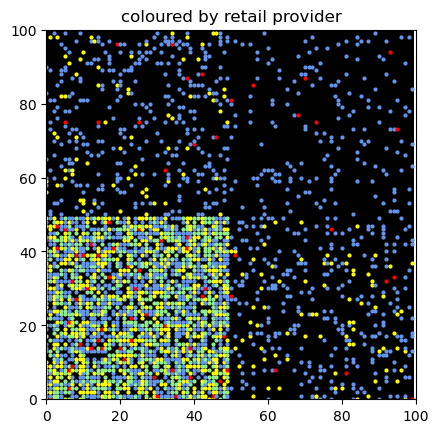

blue = Telstra
yellow = Optus/TPG
green = smallISPsCombined
red = no connection


In [87]:
#input one of the following colouring types into 'colouring desired param':
# "income", "affordability_stress_status", "tech_type", "ISP", "percent_income_spent"
colouring_desired = "ISP"

colours = plotting_func(colouring_desired)

# Adding changes over time

In [88]:
def update_data(urban_data, regional_data, remote_data, row, cell, status):
    '''helper func for bigger func below, simply adds one to the correct counter for later graphing'''
    if row < 50 and cell < 50: #urban
        if status == False:
            urban_data[0] += 1
        elif status == True:
            urban_data[1] += 1
        else:
            urban_data[2] += 1
    elif row >= 50 and cell >= 50: #remote
        if status == False:
            remote_data[0] += 1
        elif status == True:
            remote_data[1] += 1
        else:
            remote_data[2] += 1
    else: #regional
        if status == False:
            regional_data[0] += 1
        elif status == True:
            regional_data[1] += 1
        else:
            regional_data[2] += 1
    return urban_data, regional_data, remote_data
        


def simulate_market_dynamics(grid, ISPs, prob_exp, len_exp, rate_reassess, op_fee, max_iter):
    '''
    Function designed to simulate how internet prices change over time.
    Params:
        grid: an intitial state of the grid
        ISPs: the initial list of ISPs and their plans
        prob_exp: the probability that an ISP should engage in an experiment, should the option be available
        len_exp: the duration an experiment lasts for (in months)
        rate_reassess: the average number of months a user will go before assessing their internet plan options
        op_fee: the amount paid per ISP, per location active, per month, to continue to operate there 
    Output:
        three lists, one per ISP-player, where the value at each index is the profit made by the ISP that month
    '''
    
    #params to update throughout for graphing
    telstra_profit_changes = []
    optus_tpg_profit_changes = []
    smallISPsCombined_profit_changes = []
    urban_affordable = []
    urban_stressed = []
    urban_disconnected = []
    regional_affordable = []
    regional_stressed = []
    regional_disconnected = []
    remote_affordable = []
    remote_stressed = []
    remote_disconnected = []
    
    for i in tqdm(range(max_iter)):
        
        #ISP stuff
        
        #step 1: determine how much money is being made with current user base 
        telstra_gain = 0
        optus_tpg_gain = 0
        smallISPsCombined_gain = 0
        for row in range(100):
            for cell in range(100):
                if grid[row, cell, 1] == True: #if non-empty
                    plan = grid[row, cell, 3]
                    if plan[0] == 'telstra':
                        telstra_gain += plan[4]/12 #per month
                    elif plan[0] == 'optus_tpg':
                        optus_tpg_gain += plan[4]/12
                    elif plan[0] == 'smallISPsCombined':
                        smallISPsCombined_gain += plan[4]/12

        #step 2: determine how much money is being lost to 'operating fee'
        telstra_operating_fee = op_fee * len(ISPs[0][2])
        optus_tpg_operating_fee = op_fee * 2 * len(ISPs[1][2]) #cause 2 ISPs combined
        smallISPsCombined_operating_fee = op_fee * 4 * len(ISPs[2][2]) #cause 4 ISPs combined

        #step 3: update overall profit
        ISPs[0][5] = telstra_gain - telstra_operating_fee
        telstra_profit_changes.append(ISPs[0][5])
        ISPs[1][5] = (optus_tpg_gain - optus_tpg_operating_fee)/2 #per company
        optus_tpg_profit_changes.append(ISPs[1][5])
        ISPs[2][5] = (smallISPsCombined_gain - smallISPsCombined_operating_fee)/4 #per company
        smallISPsCombined_profit_changes.append(ISPs[2][5])
                
        #step 4: review pricing experiments
        #pricing_experiments are of the form either False or [plan, change, months_left, prev_profit]
        for isp in range(len(ISPs)):
            
            if ISPs[isp][3] != False: #is ISP currently engaged in a price experiment?
                price_exp = ISPs[isp][3]
                if price_exp[2] == 0: #if its time for review
                    if ISPs[isp][5] <= price_exp[3]: #if profits post-exp are worse than profits pre-exp
                        ISPs[isp][1][price_exp[0]][4] = ISPs[isp][1][price_exp[0]][4]/(1 + price_exp[1]) #revert price
                    ISPs[isp][3] = False #terminate the experiment
                else:
                    price_exp[2] -= 1 #reduce number months left of the experiment
                    ISPs[isp][3] = price_exp
            
            elif ISPs[isp][4] == False: #not currently engaged in price or location exp
                if random.random() < prob_exp: #with some probablity enter new price exp
                    targeted_plan = random.randint(0, len(ISPs[isp][1])-1)
                    current_price = ISPs[isp][1][targeted_plan][4]
                    
                    '''what should I do here? should i strategically choose to lower ot raise or randomly?'''
                    if random.random() < 0.5:
                        change = -0.05
                    else:
                        change = 0.05
                    
                    new_price = current_price + change*current_price
                    price_exp = [targeted_plan, change, len_exp, ISPs[isp][5]] #create new experiment of 6 month duration
                    ISPs[isp][1][targeted_plan][4] = new_price
                    ISPs[isp][3] = price_exp
        
        #step 5: review location experiments
        #location_experiments are of the form either False or [location, tech_types, months_left, prev_profit]
        '''for isp in range(len(ISPs)):
            
            if ISPs[isp][4] != False: #is ISP currently engaged in a location experiment?
                loc_exp = ISPs[isp][4]
                if loc_exp[2] == 0: #if its time for review
                    if ISPs[isp][5] <= loc_exp[3]: #if profits post-exp are worse than profits pre-exp
                         revert active locations
                    ISPs[isp][3] = False #terminate the experiment
                else:
                    loc_exp[2] -= 1 #reduce number months left of the experiment
                    ISPs[isp][3] = loc_exp
            
            elif ISPs[isp][3] == False: #not currently engaged in price or location exp
                if random.random() < prob_exp: #with some probablity enter new location exp
                    ISPs[isp][4] = False #dummy code for now
                    targeted_location =  # randomly choose a new locations?
                    new_tech_type = #randomly choose new price?
                    loc_exp = [targeted_location, new_tech_type, 6, ISPs[isp][5]] #create new experiment of 6 month duration
                    reflect change in ISP list
                    ISPs[isp][5] = loc_exp'''
        
        #user stuff
        
        #step 1: anyone who all of a sudden finds themselves paying over 15% of their income on their current
        #plan is prompted to immediately reassess their plan. Simulaneously, add affordability info for graphing
        amount_done_already = 0
        urban_data = [0, 0, 0]
        regional_data = [0, 0, 0]
        remote_data = [0, 0, 0]
        for row in range(100):
            for cell in range(100):
                if grid[row, cell, 1] == True:
                    if grid[row, cell, 4] != None:
                        if grid[row, cell, 3][4]/grid[row, cell, 2] * 100 >= 15:
                            new_plan = decide_plan(grid[row, cell, 0], grid[row, cell, 2], False)
                            grid[row, cell, 3] = new_plan #update plan
                            if new_plan == [None, None, None, None, None]:
                                grid[row, cell, 4] = None
                                grid[row, cell, 5] = "internet poverty"
                            else:
                                grid[row, cell, 4] = new_plan[4] / grid[row, cell, 2] * 100 #update percentage spent on plan
                                grid[row, cell, 5] = grid[row, cell, 4] > 5 #update affordability stress status
                            amount_done_already += 1
                    urban_data, regional_data, remote_data = update_data(urban_data, regional_data, remote_data, row, cell, grid[row, cell, 5])
        urban_affordable.append(urban_data[0])
        urban_stressed.append(urban_data[1])
        urban_disconnected.append(urban_data[2])
        regional_affordable.append(regional_data[0])
        regional_stressed.append(regional_data[1])
        regional_disconnected.append(regional_data[2])
        remote_affordable.append(remote_data[0])
        remote_stressed.append(remote_data[1])
        remote_disconnected.append(remote_data[2])
        
        #step 2: generating a random list of users to perform actions this iteration
        rand_users = []
        number_users_to_perform_actions = (len(grid) * len(grid[0]))//rate_reassess - amount_done_already
        while len(rand_users) < (number_users_to_perform_actions): 
            x = random.randint(0, 99)
            y = random.randint(0, 99)
            if grid[y, x, 1] == True: #if the randomly generated cell isn't empty
                rand_users.append((x, y))
            '''CONSIDERATION: so far no duplicate checking is performed due to time complexity fears'''
        
        #step 3: performing user action - choosing to switch or stay plans
        for user in rand_users:
            row = user[1]
            cell = user[0]
            new_plan = decide_plan(grid[row, cell, 0], grid[row, cell, 2], False)
            grid[row, cell, 3] = new_plan #update plan
            if new_plan == [None, None, None, None, None]:
                grid[row, cell, 4] = None
                grid[row, cell, 5] = "internet poverty"
            else:
                grid[row, cell, 4] = new_plan[4] / grid[row, cell, 2] * 100 #update percentage spent on plan
                grid[row, cell, 5] = grid[row, cell, 4] > 5 #update affordability status
                
    
    #just going throught the grid at the end and making sure all the percentages are up to date, as they
    #only get changed when a user is randomly chosen, which is fine algorithmically, but just to tidy up at end
    for row in range(100):
        for cell in range(100):
            if grid[row, cell, 1] == True:
                final_plan = grid[row, cell, 3]
                if final_plan == [None, None, None, None, None]:
                    grid[row, cell, 4] = None
                    grid[row, cell, 5] = "internet poverty"
                else:
                    grid[row, cell, 4] = final_plan[4] / grid[row, cell, 2] * 100 #update percentage spent on plan
                    grid[row, cell, 5] = grid[row, cell, 4] > 5 #update affordability status
    
    final_list_of_things_to_return = [
        telstra_profit_changes,
        optus_tpg_profit_changes,
        smallISPsCombined_profit_changes,
        urban_affordable,
        urban_stressed,
        urban_disconnected,
        regional_affordable,
        regional_stressed,
        regional_disconnected,
        remote_affordable,
        remote_stressed,
        remote_disconnected]
    
    return final_list_of_things_to_return

In [89]:
#intialise environment
ISPs, operators_per_location = initialise_ISPs()
grid = initialise_grid(ISPs, operators_per_location)
intial_grid = copy.deepcopy(grid)

#param definition and func call
prob_exp = 0.8 
len_exp = 6 
rate_reassess = 30 
#suggested rates of reassessment:
#30: assumes people consider changing their plan every 2.5 years, making 333 people change per month across grid
#len(grid)*len(grid[0])//max_iter*50: good if you want to bound the time complexity by the (max_iter*grid_size*number_plans)
op_fee = 1
max_iter = 50000
returned_things = simulate_market_dynamics(grid, ISPs, prob_exp, len_exp, rate_reassess, op_fee, max_iter)

#expand returned information
telstra_profits = returned_things[0]
optus_tpg_profits = returned_things[1]
smallISPsCombined_profits = returned_things[2]
urbanites = 0
regionites = 0
remotenites = 0
for row in range(100):
    for cell in range(100):
        if grid[row, cell, 1] == True:
            if row < 50 and cell < 50:
                urbanites += 1
            elif row >= 50 and cell >= 50:
                remotenites += 1
            else:
                regionites += 1
urban_affordable = np.array(returned_things[3])/urbanites * 100
urban_stressed = np.array(returned_things[4])/urbanites * 100
urban_disconnected = np.array(returned_things[5])/urbanites * 100
regional_affordable = np.array(returned_things[6])/regionites * 100
regional_stressed = np.array(returned_things[7])/regionites * 100
regional_disconnected = np.array(returned_things[8])/regionites * 100
remote_affordable = np.array(returned_things[9])/remotenites * 100
remote_stressed = np.array(returned_things[10])/remotenites * 100
remote_disconnected = np.array(returned_things[11])/remotenites * 100

100%|█████████████████████████████████████| 50000/50000 [10:20<00:00, 80.56it/s]


## E.g. Plotting profits over time

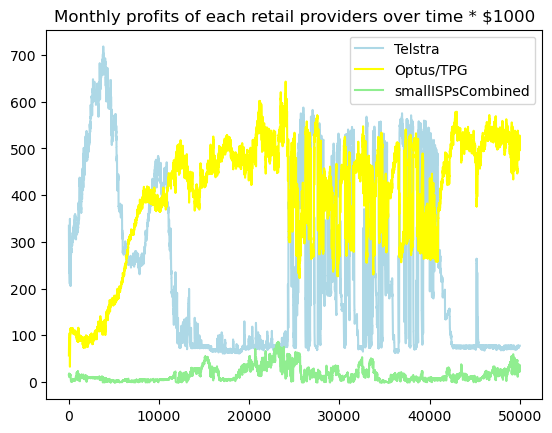

In [90]:
#plot profits
x = range(max_iter)
plt.plot(x, telstra_profits, label="Telstra", color="lightblue")
plt.plot(x, optus_tpg_profits, label="Optus/TPG", color="yellow")
plt.plot(x, smallISPsCombined_profits, label="smallISPsCombined", color="lightgreen")
plt.title("Monthly profits of each retail providers over time * $1000")
plt.legend()
plt.show()

## E.g. Plotting the percentage of users experiencing affordability stress over time 

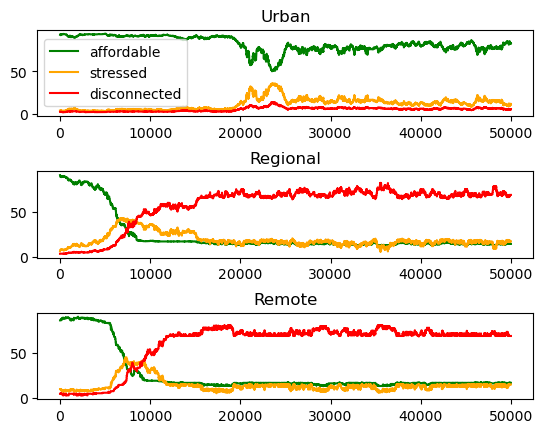

In [91]:
#plot affordability stress over time
plot1 = plt.subplot2grid((8, 1), (0, 0), rowspan=2, colspan=1)
plot2 = plt.subplot2grid((8, 1), (3, 0), rowspan=2, colspan=1)
plot3 = plt.subplot2grid((8, 1), (6, 0), rowspan=2, colspan=1)
x = range(max_iter)
plot1.plot(x, urban_affordable, label="affordable", color="green")
plot1.plot(x, urban_stressed, label="stressed", color="orange")
plot1.plot(x, urban_disconnected, label="disconnected", color="red")
plot1.set_title("Urban")
plot2.plot(x, regional_affordable, label="affordable", color="green")
plot2.plot(x, regional_stressed, label="stressed", color="orange")
plot2.plot(x, regional_disconnected, label="disconnected", color="red")
plot2.set_title("Regional")
plot3.plot(x, remote_affordable, label="affordable", color="green")
plot3.plot(x, remote_stressed, label="stressed", color="orange")
plot3.plot(x, remote_disconnected, label="disconnected", color="red")
plot3.set_title("Remote")
plot1.legend()
plt.show()

# The real-life figure from the 2023 ADII report
https://www.digitalinclusionindex.org.au/wp-content/uploads/2023/07/ADII-2023-Summary_FINAL-Remediated.pdf

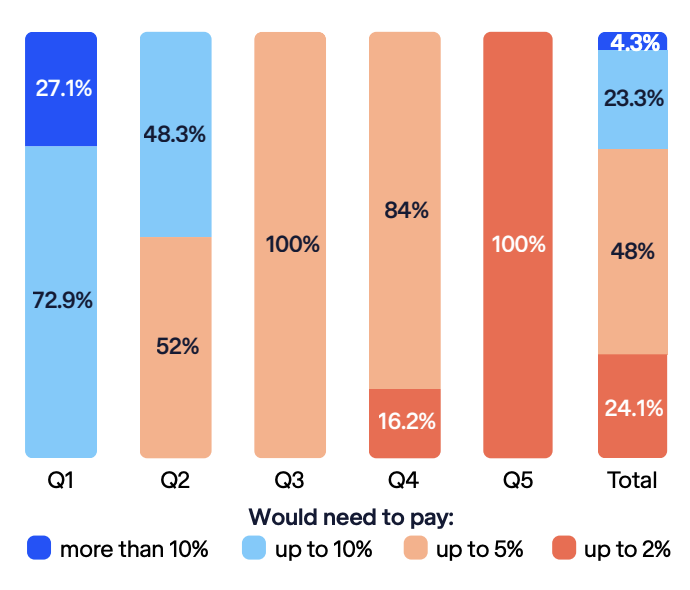

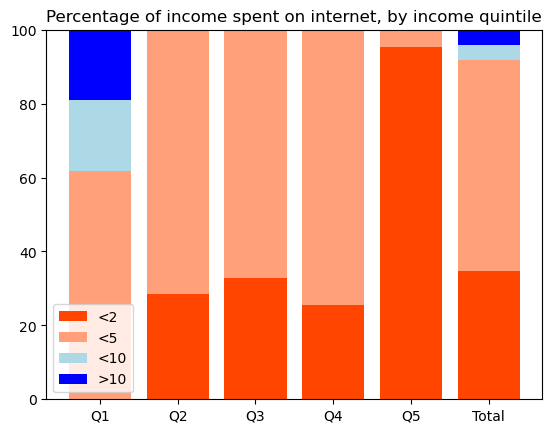

In [104]:
recreate_ADII_figure(intial_grid)

## Printing the intitial states:

In [95]:
after_grid = copy.deepcopy(grid)
grid = intial_grid
#ISPs, operators_per_location = initialise_ISPs()
#grid = initialise_grid(ISPs, operators_per_location)

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 79.73it/s]


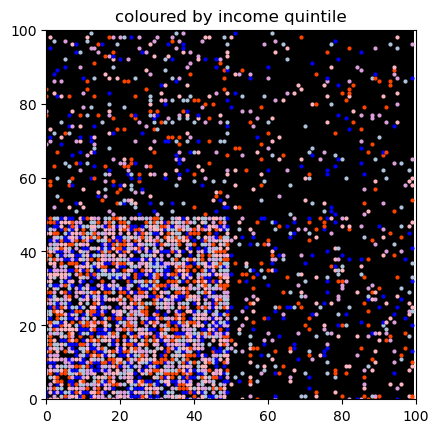

red -> blue = low income -> high income


In [75]:
#input one of the following colouring types into 'colouring desired param':
# "income", "affordability_stress_status", "tech_type", "ISP", "percent_income_spent"
colouring_desired = "income"

colours = plotting_func(colouring_desired)

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 79.41it/s]


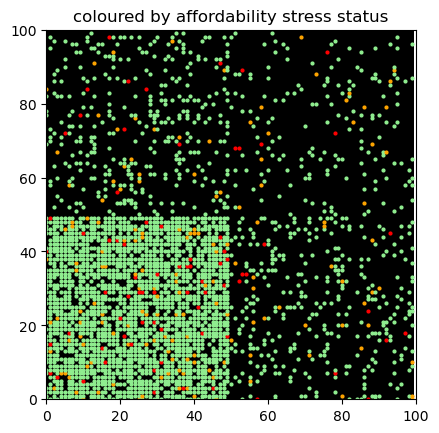

green = no stress
orange = affordability stress
red = internet poverty (no connection)


In [76]:
#input one of the following colouring types into 'colouring desired param':
# "income", "affordability_stress_status", "tech_type", "ISP", "percent_income_spent"
colouring_desired = "affordability_stress_status"

colours = plotting_func(colouring_desired)

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 81.03it/s]


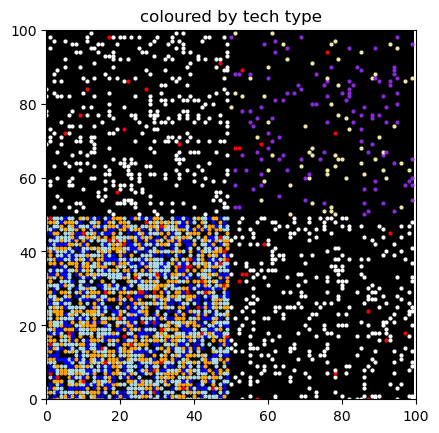

dark blue = FTTP
light blue = FTTN
orange = HFC
white = fixed wireless
purple = satellite
yellow = mobile
red = no connection


In [77]:
#input one of the following colouring types into 'colouring desired param':
# "income", "affordability_stress_status", "tech_type", "ISP", "percent_income_spent"
colouring_desired = "tech_type"

colours = plotting_func(colouring_desired)

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 80.30it/s]


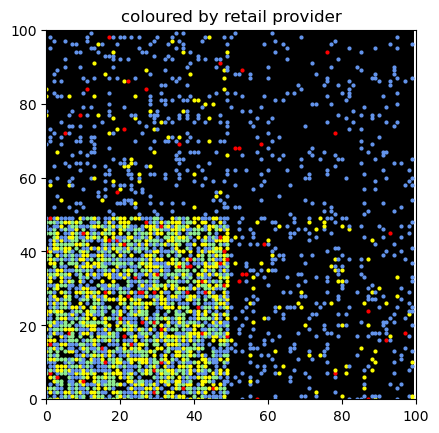

blue = Telstra
yellow = Optus/TPG
green = smallISPsCombined
red = no connection


In [78]:
#input one of the following colouring types into 'colouring desired param':
# "income", "affordability_stress_status", "tech_type", "ISP", "percent_income_spent"
colouring_desired = "ISP"

colours = plotting_func(colouring_desired)

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 81.84it/s]


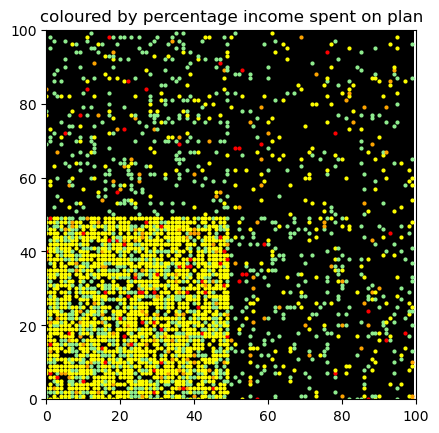

green = up to 2%
yellow = between 2-5%
orange = over 5%
red = internet poverty (no plan exists under 15% of income)


In [79]:
#input one of the following colouring types into 'colouring desired param':
# "income", "affordability_stress_status", "tech_type", "ISP", "percent_income_spent"
colouring_desired = "percent_income_spent"

colours = plotting_func(colouring_desired)

## Printing the end states:

In [96]:
grid = after_grid

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 85.13it/s]


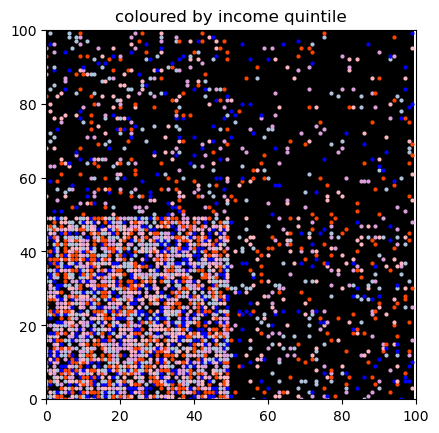

red -> blue = low income -> high income


In [97]:
#input one of the following colouring types into 'colouring desired param':
# "income", "affordability_stress_status", "tech_type", "ISP", "percent_income_spent"
colouring_desired = "income"

colours = plotting_func(colouring_desired)

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 82.62it/s]


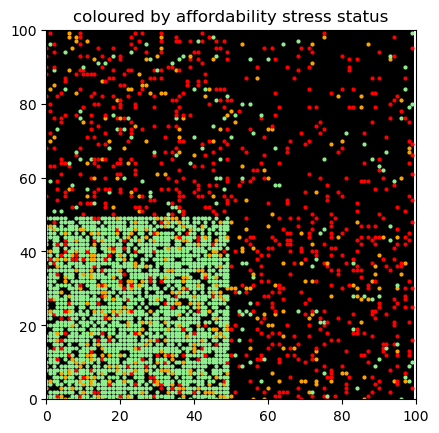

green = no stress
orange = affordability stress
red = internet poverty (no connection)


In [98]:
#input one of the following colouring types into 'colouring desired param':
# "income", "affordability_stress_status", "tech_type", "ISP", "percent_income_spent"
colouring_desired = "affordability_stress_status"

colours = plotting_func(colouring_desired)

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 80.58it/s]


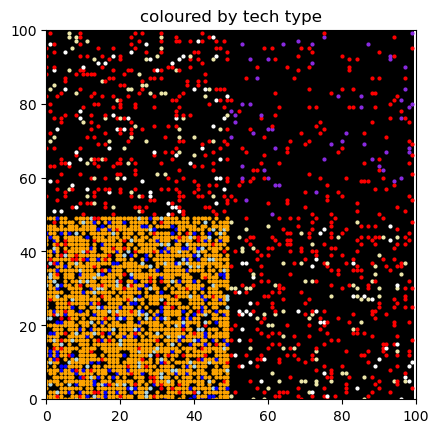

dark blue = FTTP
light blue = FTTN
orange = HFC
white = fixed wireless
purple = satellite
yellow = mobile
red = no connection


In [99]:
#input one of the following colouring types into 'colouring desired param':
# "income", "affordability_stress_status", "tech_type", "ISP", "percent_income_spent"
colouring_desired = "tech_type"

colours = plotting_func(colouring_desired)

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 78.25it/s]


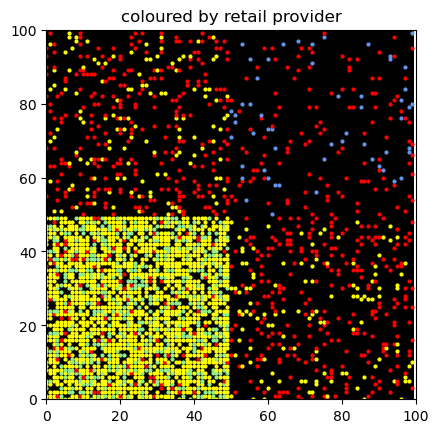

blue = Telstra
yellow = Optus/TPG
green = smallISPsCombined
red = no connection


In [100]:
#input one of the following colouring types into 'colouring desired param':
# "income", "affordability_stress_status", "tech_type", "ISP", "percent_income_spent"
colouring_desired = "ISP"

colours = plotting_func(colouring_desired)

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 80.02it/s]


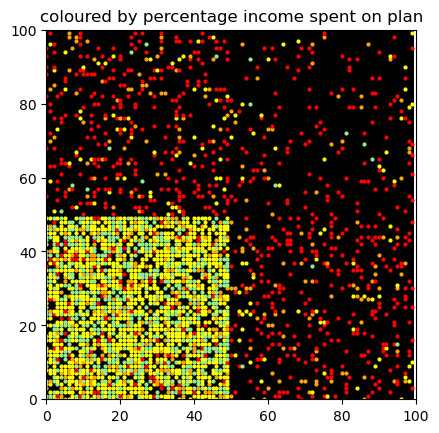

green = up to 2%
yellow = between 2-5%
orange = over 5%
red = internet poverty (no plan exists under 15% of income)


In [101]:
#input one of the following colouring types into 'colouring desired param':
# "income", "affordability_stress_status", "tech_type", "ISP", "percent_income_spent"
colouring_desired = "percent_income_spent"

colours = plotting_func(colouring_desired)